In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import random
import numpy as np

from amd.rocal.plugin.pytorch import ROCALClassificationIterator
import torch
torch.set_printoptions(threshold=10_000)
from amd.rocal.pipeline import Pipeline
import amd.rocal.fn as fn
import amd.rocal.types as types
# import rocal_pybind.tensor
import sys
import cv2
import os
import matplotlib.pyplot as plt
import librosa as librosa
import librosa.display


/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [2]:
def show_spectrogram(spec, title, sr, hop_length, y_axis='log', x_axis='time'):
    librosa.display.specshow(spec, sr=16000, y_axis=y_axis, x_axis=x_axis, hop_length=hop_length)
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

In [3]:

# data_path = "/media/audio_samples/MIVisionX-data/rocal_data/audio_samples/audio_wav_files/"
# file_list = "/media/audio_samples/MIVisionX-data/rocal_data/audio_samples/audio_file_list.txt"
data_path = "/media/audio_samples/MIVisionX-data/check/three.wav"
# data_path = "/media/audio_samples/MIVisionX-data/rocal_data/audio_samples/audio_wav_files/19/198/19-198-0000.wav"

file_list = "/media/audio_samples/MIVisionX-data/txt_file.txt"

_rali_cpu = True
hop_length=512
batch_size = 1
num_threads = 1
device_id = 0
random_seed = random.SystemRandom().randint(0, 2**32 - 1)
print(random_seed)
crop=300

pipe = Pipeline(batch_size=batch_size, num_threads=num_threads,device_id=device_id, seed=random_seed, rocal_cpu=_rali_cpu)
local_rank = 0
world_size = 1

print("*********************************************************************")


    

2286676558
Pipeline has been created succesfully
*********************************************************************


[INF]  {compute_optimum_internal_batch_size}  Can run 24 threads simultaneously on this machine
[INF]  {compute_optimum_internal_batch_size}  User batch size 1 Internal batch size set to 1

OK: loaded 98 kernels from libvx_rpp.so
OK: loaded 2 kernels from libvx_amd_media.so


16000


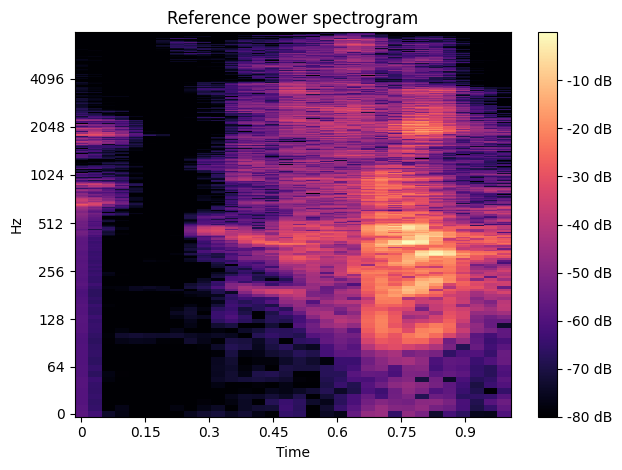

In [4]:
y, sr = librosa.load(data_path,sr=16000)
n_fft=2048
hop_length=512
print(sr)
# Calculate the spectrogram as the square of the complex magnitude of the STFT
spectrogram_librosa = np.abs(librosa.stft(
    y, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window='hann', pad_mode='reflect')) ** 2
spectrogram_librosa_db = librosa.power_to_db(spectrogram_librosa, ref=np.max)
show_spectrogram(spectrogram_librosa_db, 'Reference power spectrogram', sr, hop_length)
# plt.plot(spectrogram_librosa)
# plt.show()
# for i in range(100):
#     print("librosa decoded val  ",y[i])
# print(spectrogram_librosa)
# for i in range (10):
#     for j in range (10):
#         print(spectrogram_librosa[i][j])


In [5]:
# test_data_root = os.environ['DALI_EXTRA_PATH']
# sample_data = os.path.join(test_data_root, 'db', 'audio', 'wav', '237-134500-0000.wav')

# # Size of the FFT, which will also be used as the window length
# n_fft=2048

# # Step or stride between windows. If the step is smaller than the window lenght, the windows will overlap
# hop_length=512

# # Load sample audio file
# y, sr = librosa.load(sample_data)

# # Calculate the spectrogram as the square of the complex magnitude of the STFT
# spectrogram_librosa = np.abs(librosa.stft(
#     y, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window='hann', pad_mode='reflect')) ** 2

In [6]:
data_path = "/media/audio_samples/MIVisionX-data/check/"
# file_list = "/media/audio_samples/MIVisionX-data/txt_file.txt"

audio_pipeline = Pipeline(batch_size=batch_size, num_threads=num_threads, device_id=device_id, seed=3621326981, rocal_cpu=_rali_cpu)

Pipeline has been created succesfully
OK: loaded 98 kernels from libvx_rpp.so


[INF] 

OK: loaded 2 kernels from libvx_amd_media.so


 {compute_optimum_internal_batch_size}  Can run 24 threads simultaneously on this machine
[INF]  {compute_optimum_internal_batch_size}  User batch size 1 Internal batch size set to 1


In [7]:
with audio_pipeline:
    audio, label = fn.readers.file(
        # **files_arg,
        file_root=data_path,
        file_list=file_list,
        shard_id=0,
        num_shards=8,)
    sample_rate = 16000
    nfft=2048
    window_size=0.02
    window_stride=0.01
    nfilter=80 #nfeatures
    resample = 1
    audio_decode = fn.decoders.audio(audio, file_root=data_path, downmix=True, sample_rate=sample_rate*resample, shard_id=0, num_shards=8)
#     for i in range(100):
#         print(audio_decode[i])
    spectrogram_audio = fn.spectrogram(
            audio_decode,
            nfft=nfft,
            window_length=2048, # Change to 320
            window_step= 512, # Change to 160
            rocal_tensor_output_type=types.FLOAT,
            
        )
#     mel_filter_bank_audio = fn.mel_filter_bank(
#             spectrogram_audio,
#             sample_rate=sample_rate,
#             nfilter=nfilter,
#         )
    audio_pipeline.set_outputs(spectrogram_audio)



OUT LIST LEN :  1


[INF]  {rocalAudioFileSourceSingleShard}  Internal buffer size for audio frames = 16000


In [8]:
audio_pipeline.build()
audioIteratorPipeline = ROCALClassificationIterator(audio_pipeline)

Call RPP spectogramReturn from RPP spectogram
 rocAL graph verified[INF]  {output_routine}  Output routine started with 1 to load


audio_data = audioIteratorPipeline
for i , it in enumerate(audioIteratorPipeline):
    a= it[0].numpy()
    print(type(a))
    print(a.shape)
    b=a[0]
    print(b.shape)
    b= b.flatten()
    print(b.shape)
    print(b)
    plt.plot(b)
    val =0.
    plt.plot(np.arange(-2,2,.5),b, 'x')
    

    
    




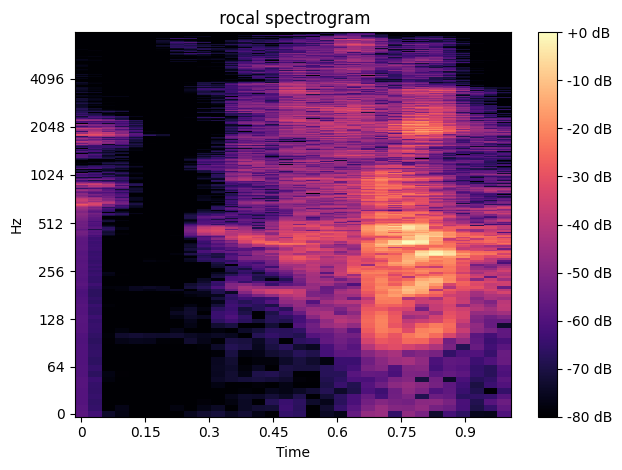

In [9]:
for i , it in enumerate(audioIteratorPipeline):
    num_array=it[0][0].numpy()
    num_array=num_array.flatten()
    num_array=num_array.reshape(1025,32)
#     print("num_array.shape ",num_array)
#     print("rocal spectro val ",num_array)
#     for i in range (100):
#         for j in range(10):
#         print(num_array[i])
#     print("num_array  ",num_array)
    spectrogram_dali_db = librosa.power_to_db(num_array, ref=np.max)
#     print("spectrogram_dali_db ")
# #     for i in range(100):
# #         for j in range (100):
# #             print(spectrogram_dali_db[i][j])
    
    show_spectrogram(spectrogram_dali_db, ' rocal spectrogram', sample_rate, hop_length)
#     print(type(spectrogram_dali_db))
#     exit()
#     for i in range(32):
#         for j in range(1025):
#             print(num_array[i][j])

#     plt.plot(num_array)
#     plt.show()

